#Anomaly detection using Autoencoder (PyTorch)

## Install requirements

In [ ]:
%pip install tsne-torch

In [ ]:
! pip install kaggle

## Import libraries

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
from sklearn.manifold import TSNE
import numpy as np

## Load data

In [ ]:
! mkdir ~/.kaggle

In [5]:
cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
^C


In [ ]:
! unzip new-plant-diseases-dataset.zip

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## ِ Visualize data

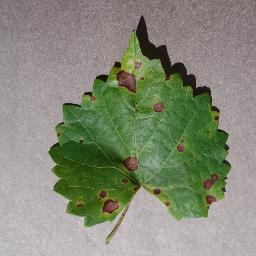

In [80]:
img = Image.open('/Users/nguyenphan/Developer/Leaf-Anomaly-Detection/grape-only-dataset/train/Grape___Black_rot/0b9d95bb-51c7-40f1-8a4b-f9838becb418___FAM_B.Rot 0493.JPG')
img

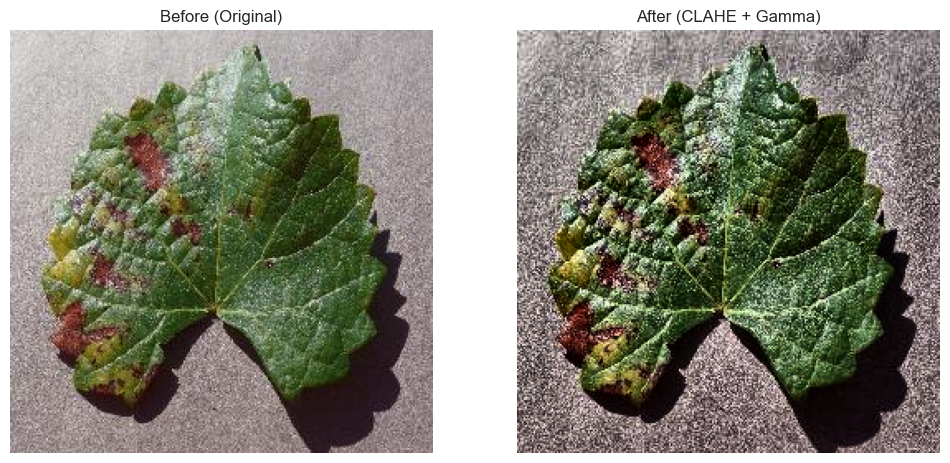

In [119]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Đọc ảnh gốc
img = Image.open('/Users/nguyenphan/Developer/Leaf-Anomaly-Detection/grape-only-dataset/train/Grape___Esca_(Black_Measles)/eb4b029a-c930-444b-ae7f-337085696357___FAM_B.Msls 3962.JPG')

# Hàm CLAHE
def apply_clahe(img_pil):
    img = np.array(img_pil)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return Image.fromarray(img_clahe)

# Hàm Gamma Correction
def apply_gamma(img_pil, gamma=1.5):
    img = np.array(img_pil) / 255
    img_gamma = np.power(img, gamma)
    img_gamma = np.uint8(img_gamma * 255)
    return Image.fromarray(img_gamma)

# Áp dụng CLAHE và Gamma Correction
img_clahe = apply_clahe(img)
img_gamma = apply_gamma(img_clahe, gamma=1.5)

# Hiển thị ảnh before & after
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Before (Original)')
plt.imshow(img)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('After (CLAHE + Gamma)')
plt.imshow(img_gamma)
plt.axis('off')

plt.show()

## Building train set

In [81]:
train_path = "/Users/nguyenphan/Developer/Leaf-Anomaly-Detection/grape-only-dataset/train"

# train_path = "/Users/nguyenphan/Developer/Leaf-Anomaly-Detection/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

In [82]:
def get_label(name):
  label = 0
  if bool(re.match('Grape___E.+', name)):
    label = 1
  elif bool(re.match('Grape___L.+', name)):
    label = 2
  elif bool(re.match('Grape___h.+', name)):
    label = 3
  return label

In [83]:
convert_tensor = transforms.ToTensor()
train_data = []
for root, dirs, files in os.walk(train_path):
  class_name = root.split('/')[-1]
  if bool(re.match('Grape.+', class_name)):
    for file in files:
      path = os.path.join(root, file)
      img = Image.open(path)
      tensor_img = convert_tensor(img)
      tensor_img = tensor_img.to(device)
      label = get_label(class_name)
      train_data.append([tensor_img, label])

print(len(train_data))

1443


In [84]:
train_data[0][0].is_cuda

False

In [90]:
train_loader = torch.utils.data.DataLoader(
    dataset= train_data,
    batch_size=16
)

In [86]:
from torch.utils.data import Dataset, DataLoader

class LeafDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][0], self.data[idx][1]

# Tạo dataset và dataloader
train_dataset = LeafDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
# train_iter = iter(train_loader)
# train_images, train_labels = train_iter.next()
# print(train_images.shape, '  ', train_labels.shape)

In [ ]:
# print(torch.min(train_images), torch.max(train_images))

## Building Model

In [87]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=7, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=7, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=5)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=5),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=7, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=7, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=1, output_padding=1),
        nn.Sigmoid() # As we saw that the input tensors are between 0 and 1 so we should use an activation function to map our values to that range.
    )
    
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import SSIM

class AnomalyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2):
        super().__init__()
        self.alpha = alpha  # Hệ số cho MSE
        self.beta = beta    # Hệ số cho SSIM
        self.gamma = gamma  # Hệ số cho L1 Loss
        self.ssim = SSIM(data_range=1.0, size_average=True, channel=3)

    def forward(self, y_pred, y_true):
        # MSE Loss
        mse = F.mse_loss(y_pred, y_true)

        # SSIM Loss (1 - SSIM vì SSIM càng cao càng tốt)
        ssim = 1 - self.ssim(y_pred, y_true)

        # L1 Loss
        l1 = F.l1_loss(y_pred, y_true)

        # Kết hợp các loss
        total_loss = self.alpha * mse + self.beta * ssim + self.gamma * l1

        return total_loss

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class CustomLoss(nn.Module):
#     def forward(self, y_pred, y_true):
#         mse = F.mse_loss(y_pred, y_true)
#         bce = F.binary_cross_entropy(y_pred, y_true)
#         return mse + bce
    
# Sử dụng loss function
criterion = AnomalyLoss()
model = Autoencoder()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
print(img.min().item(), img.max().item())   # nên thấy 0.0  1.0


In [ ]:
num_epochs = 1000
# outputs = []
for epoch in range(num_epochs):
    for (img, _) in train_loader:
      recon = model(img)
      loss = criterion(recon, img)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    # outputs.append((epoch, img, recon))
  

## Building test set

In [94]:
test_path = "/Users/nguyenphan/Developer/Leaf-Anomaly-Detection/grape-only-dataset/test/test"

In [95]:
convert_tensor = transforms.ToTensor()
test_data = []
test_label = []
for root, dirs, files in os.walk(test_path):
    for file in files:
      path = os.path.join(root, file)
      img = Image.open(path)
      tensor_img = convert_tensor(img)
      tensor_img = tensor_img.to(device)
      test_data.append([tensor_img, 4])
      test_label.append('Anomaly')

print(len(test_data))

33


In [96]:
test_data = test_data[:28]
test_label = test_label[:28]

adding un-anomaly data to test set:

In [97]:
val_path = '/Users/nguyenphan/Developer/Leaf-Anomaly-Detection/grape-only-dataset/valid'

In [98]:
count = [0 for i in range(4)]

for root, dirs, files in os.walk(val_path):
  class_name = root.split('/')[-1]
  if bool(re.match('Grape.+', class_name)):
    for file in files:
      label = get_label(class_name)
      count[label] += 1
      if count[label] >= 18:
        break
      path = os.path.join(root, file)
      img = Image.open(path)
      tensor_img = convert_tensor(img)
      tensor_img = tensor_img.to(device)
      test_data.append([tensor_img, label])
      test_label.append(label)


print(len(test_data))

96


In [99]:
test_data[0][0].is_cuda

False

In [100]:
test_loader = torch.utils.data.DataLoader(
    dataset= test_data,
    batch_size=8,
    shuffle=False
)

## Test model

In [101]:
torch.cuda.empty_cache() 

In [102]:
encodes = []

for (img, _) in test_loader:
  code = model.encoder(img)
  encodes.append(torch.tensor(code, device = 'cpu'))
  
len(encodes)

/var/folders/xn/gcs9_0wd2tj2hcfjwzx7srzm0000gn/T/ipykernel_14142/1157503760.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodes.append(torch.tensor(code, device = 'cpu'))


12

In [103]:
[t.shape for t in encodes]

[torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25])]

In [106]:
y = []
tsne = TSNE(perplexity=5)
for t in encodes:
  x = t.reshape(8, -1)
  embd = tsne.fit_transform(x)
  y.append(embd)

len(y)

12

In [107]:
y[7]

array([[ 45.78558  , -54.00498  ],
       [-49.134197 ,  62.660618 ],
       [ 56.729645 ,  22.353254 ],
       [ 20.63157  , -16.92715  ],
       [-21.614977 ,   5.9986835],
       [ -4.056575 ,  63.09021  ],
       [-38.350185 , -80.4148   ],
       [-70.72995  , -52.434605 ]], dtype=float32)

In [108]:
x = []
for i in range(len(y)):
  for j in y[i]:
    x.append(j)

len(x)

96

In [ ]:
# ttt = np.array(x)
# list(map(lambda i : i[0], x))

<Axes: >

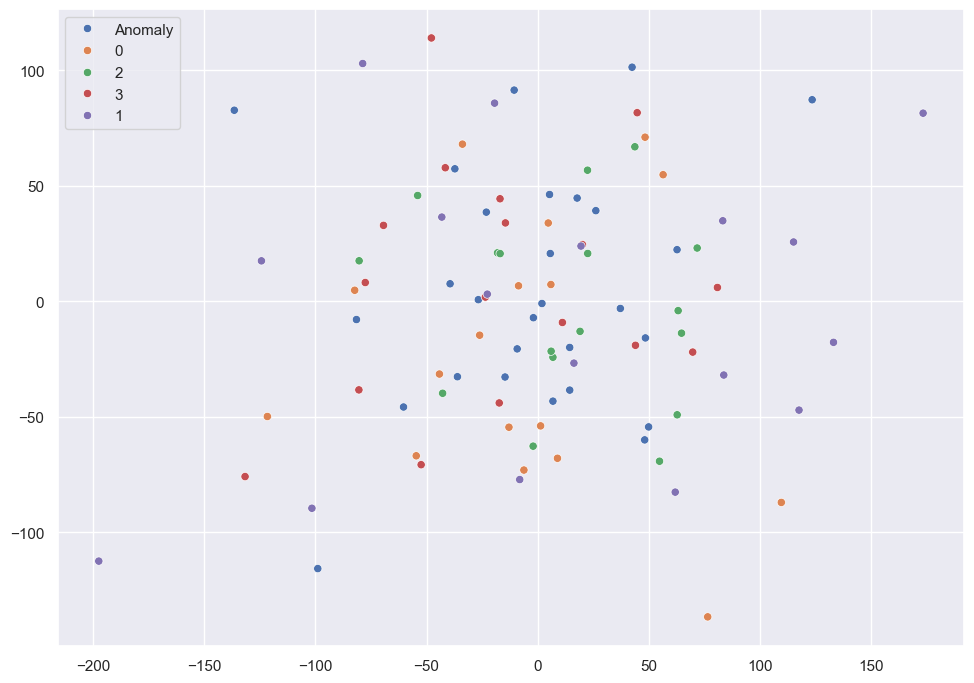

In [111]:
import seaborn as sns

# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.scatterplot(list(map(lambda i : i[0], x)), list(map(lambda i : i[1], x)), hue=test_label)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x = list(map(lambda i : i[1], x)), y = list(map(lambda i : i[0], x)), hue=test_label)